# COMP 551 AML Assignment 2
## Ran Cheng, 260768706
This project is for assignment 2 of applied machine learning course.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# read classifier data, mean
ds1_m0_data = pd.read_csv('./Data/DS1_m_0.txt', sep=",", header=None)
ds1_m0_data = ds1_m0_data.dropna(axis=1, how='all')
ds1_m0 = np.squeeze(np.asarray(ds1_m0_data))
ds1_m1_data = pd.read_csv('./Data/DS1_m_1.txt', sep=",", header=None)
ds1_m1_data = ds1_m1_data.dropna(axis=1, how='all')
ds1_m1 = np.squeeze(np.asarray(ds1_m1_data))
print(ds1_m0, ds1_m1)

[1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3
 1.3 1.3] [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [3]:
# read covarience matrrix
ds1_cov_data = pd.read_csv('./Data/DS1_Cov.txt', sep=",", header=None)
ds1_cov_data = ds1_cov_data.dropna(axis=1, how='all')
ds1_cov = np.squeeze(np.asarray(ds1_cov_data))
ds1_cov.shape

(20, 20)

In [4]:
# get the data for classifier, 0
out_0 = np.random.multivariate_normal(ds1_m0, ds1_cov, size=2000)
label_0 = np.zeros((2000,1))
labeled_ds1_0 = np.hstack((out_0, label_0))
# get the data for classifier, 1
out_1 = np.random.multivariate_normal(ds1_m1, ds1_cov, size=2000)
label_1 = np.ones((2000,1))
labeled_ds1_1 = np.hstack((out_1, label_1))
print(labeled_ds1_0[0], labeled_ds1_1[1])

[ 1.9702043   3.03789074  3.28712392  3.28600391  1.79457394  2.91898175
  2.99612094  3.66027886  0.26438647  2.61549723  0.09369434  2.86043891
  4.02082908  1.71412364  1.31972489 -0.08539944  1.52492203  1.7726729
  2.80412515  2.83667858  0.        ] [4.19178202 3.89695641 1.98806985 1.42373825 2.1351006  3.03747225
 3.6219948  3.5228176  2.86818781 0.7028925  2.27923605 4.63187375
 1.6245087  2.49813526 2.4458938  4.00662833 3.86376831 3.42522617
 4.5177326  1.32008163 1.        ]


In [5]:
# concaternate negative and positive data
merged_ds1 = np.vstack((labeled_ds1_0,labeled_ds1_1))
# shuffle the negative and positive data
np.random.shuffle(merged_ds1)
#np.savetxt("DS1.csv", merged_ds1, delimiter=",")
# get the data split into two parts randomly: training and testing data
train, test = train_test_split(merged_ds1, test_size=0.3)
n = train.shape[0]
n_test = test.shape[0]

In [6]:
mu1 = np.mean(train[train[0:,-1] == 1][0:,0:-1], axis=0) #mu1 hat
mu0 = np.mean(train[train[0:,-1] == 0][0:,0:-1], axis=0) #mu1 hat
mu0.shape

(20,)

In [7]:
n_0 = len(train[train[0:,-1] == 0])
n_1 = len(train[train[0:,-1] == 1])
p_y0 = n_0/n
p_y1 = n_1/n
print('n_0: % d,' % n_0, ' n_1: % d' % n_1)

n_0:  1394,  n_1:  1406


In [8]:
s1 = train[train[0:,-1] == 1][0:, 0:-1] - mu1
sig1 =  np.dot(s1.transpose(), s1)
s0 = train[train[0:,-1] == 1][0:, 0:-1] - mu0
sig0 =  np.dot(s0.transpose(), s0)
sigma = (sig0 + sig1)/n
invsig = np.linalg.inv(sigma)

In [9]:
# estimate w0 and w1
w_0 = np.log(p_y0) - np.log(p_y1) - (1/2)*(np.dot(np.dot(mu0.transpose(), invsig), mu0)) + (1/2)*(np.dot(np.dot(mu1.transpose(), invsig), mu1))
w_1 = np.dot(invsig, (mu0 - mu1))
print('w0: %0.4f' % w_0, 'w1: ', w_1)

w0: 3.9838 w1:  [ 2.06477994 -1.25471073 -0.855906   -0.58358224 -1.42189548 -0.63569193
  2.57998318 -3.45045205 -4.27487722  1.28159986 -1.89281825 -1.84757829
  2.31854499  1.94551299 -0.80107516  1.8637994   4.36818708 -0.94372199
 -0.2076562  -0.66452819]


In [10]:
tmp = np.dot(test[0:,0:-1], w_1)
result = w_0 + tmp
result[result >= 0] = 0
result[result < 0] = 1
error = sum(result != test[:,-1])
print("The error rate of the estimation on the testing set is {0}/{1} or : {2}%"\
          .format(error, n_test, 100*error/n_test))

The error rate of the estimation on the testing set is 70/1200 or : 5.833333333333333%


In [11]:
# fit metric
from sklearn.metrics import classification_report
y_true = test[:,-1]
y_pred = result
print(classification_report(y_true, y_pred, target_names=['class 0', 'class 1']))

             precision    recall  f1-score   support

    class 0       0.95      0.94      0.94       606
    class 1       0.94      0.94      0.94       594

avg / total       0.94      0.94      0.94      1200



In [12]:
# use KNN to fit data
from collections import Counter
class KNearestNeighbors(object):
    
    def __init__(self,k,distance):
        self.k=k
        self.distance=distance
        self.X_train=np.asarray([])
        self.y_train=np.asarray([])
        
    def fit(self,X,y):
        self.X_train=X
        self.y_train=y
        
    def predict(self,X):
        X=X.reshape((-1,self.X_train.shape[1]))
        
        #Creating matrix to store distance
        distances=np.zeros((X.shape[0],self.X_train.shape[0]))
        for i,x in enumerate(X):
            for j,x_train in enumerate(self.X_train):
                distances[i,j]=self.distance(x_train,x)
        #Storing the indices of top k elements where distance is in increasing order
        sorted_indices=distances.argsort()[:,:self.k]
        top_k = self.y_train[sorted_indices]  #sort and take top k
        result = np.zeros(X.shape[0])
        for i, values in enumerate(top_k):
            result[i] = Counter(values).most_common(1)[0][0]
        return result

In [13]:
#Computes the euclidean distance

def euclidean_distance(a,b):
    distance=np.sqrt(np.dot(a-b,a-b))
    return distance

#Computes cosine similarity between the two vectors

def cosine_distance(a,b):
       
    distance=1-np.dot(a,b)/np.sqrt(np.dot(a,a)*np.dot(b,b))
    return distance

In [14]:
knn = KNearestNeighbors(6, euclidean_distance)
knn.fit(train[:,0:-1], train[:,-1])
knn_res = knn.predict(test[:,0:-1])
knn_res.shape
print(y_true, knn_res)

[0. 1. 1. ... 1. 1. 0.] [1. 0. 0. ... 1. 0. 0.]


In [15]:
print(classification_report(y_true, knn_res, target_names=['class 0', 'class 1']))

             precision    recall  f1-score   support

    class 0       0.51      0.54      0.53       606
    class 1       0.50      0.47      0.49       594

avg / total       0.51      0.51      0.51      1200



In [16]:
from sklearn.metrics import precision_recall_fscore_support
p_set = []
r_set = []
f1_set= []
s_set = []
for i in range(20):
    knn = KNearestNeighbors(i+1, euclidean_distance)
    knn.fit(train[:,0:-1], train[:,-1])
    test_result = knn.predict(test[:,0:-1])
    p, r, f1, s = precision_recall_fscore_support(y_true, test_result, average='binary')
    p_set.append(p)
    r_set.append(r)
    f1_set.append(f1)
    s_set.append(s)

best fit result: k=18 


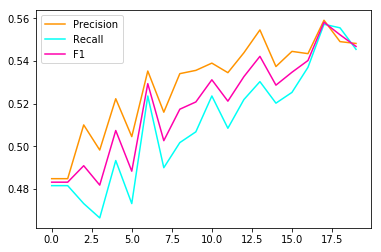

In [17]:
from matplotlib import cm
plt.plot(p_set, c=cm.hsv(0.1), label='Precision')
plt.plot(r_set, c=cm.hsv(0.5), label='Recall')
plt.plot(f1_set, c=cm.hsv(0.9), label='F1')
plt.legend(loc='upper left')
print('best fit result: k=%d '%(p_set.index(max(p_set))+1))

### Q3. Generate Multi-Gaussian-Model

In [26]:
def read_mean(filename):
    mean_data = pd.read_csv(filename, sep=",", header=None)
    mean_data = mean_data.dropna(axis=1,how='all')
    mean_data = np.squeeze(np.asarray(mean_data))
    return mean_data
def read_cov(filename):
    cov_data = pd.read_csv(filename, sep=",", header=None)
    cov_data = cov_data.dropna(axis=1, how='all')
    cov_data = np.squeeze(np.asarray(cov_data))
    return cov_data

In [27]:
# read classifier data, mean
# positive class
ds2_c1_m1 = read_mean('./Data/DS2_c1_m1.txt')
ds2_c1_m2 = read_mean('./Data/DS2_c1_m2.txt')
ds2_c1_m3 = read_mean('./Data/DS2_c1_m3.txt')
# negative class
ds2_c2_m1 = read_mean('./Data/DS2_c2_m1.txt')
ds2_c2_m2 = read_mean('./Data/DS2_c2_m2.txt')
ds2_c2_m3 = read_mean('./Data/DS2_c2_m3.txt')

print(ds2_c1_m1,'\n', ds2_c1_m2,'\n', ds2_c1_m3,'\n', ds2_c2_m1,'\n', ds2_c2_m2,'\n', ds2_c2_m3)
# read covarience matrices
ds2_cov1 = read_cov('./Data/DS2_Cov1.txt')
ds2_cov2 = read_cov('./Data/DS2_Cov2.txt')
ds2_cov3 = read_cov('./Data/DS2_Cov3.txt')

# get the data for classifier, negative class
ds2_positive_out1 = np.random.multivariate_normal(ds2_c1_m1, ds2_cov1_data, size=2000)
ds2_positive_out2 = np.random.multivariate_normal(ds2_c1_m2, ds2_cov2_data, size=2000)
ds2_positive_out3 = np.random.multivariate_normal(ds2_c1_m3, ds2_cov3_data, size=2000)
ds2_negative_out1 = np.random.multivariate_normal(ds2_c2_m1, ds2_cov1_data, size=2000)
ds2_negative_out2 = np.random.multivariate_normal(ds2_c2_m2, ds2_cov1_data, size=2000)
ds2_negative_out3 = np.random.multivariate_normal(ds2_c2_m3, ds2_cov1_data, size=2000)
# multi-gaussian model combine: 0.1,0.42,0.48
positive_out = (0.1*ds2_positive_out1 + 0.42*ds2_positive_out2 + 0.48*ds2_positive_out3)
negative_out = (0.1*ds2_negative_out1 + 0.42*ds2_negative_out2 + 0.48*ds2_negative_out3)
labeled_ds2_positive_out = np.hstack((positive_out, label_1))
labeled_ds2_negative_out = np.hstack((negative_out, label_0))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 [0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7
 0.7 0.7] 
 [1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3
 1.3 1.3] 
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.] 
 [1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7 1.7
 1.7 1.7] 
 [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6]


In [28]:
# concaternate negative and positive data
merged_ds2 = np.vstack((labeled_ds2_positive_out,labeled_ds2_negative_out))
# shuffle the negative and positive data
np.random.shuffle(merged_ds2)
# np.savetxt("DS2.csv", merged_ds2, delimiter=",")